In [ ]:
#!pip install sktime
#!pip install pmdarima

In [ ]:
import pandas as pd 
import numpy as np
import seaborn as sns
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import os
from statsmodels.tsa.stattools import adfuller
from scipy.stats import normaltest
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error
from sktime.performance_metrics.forecasting import MeanAbsolutePercentageError
from sktime.utils.plotting import plot_series , plot_windows , plot_correlations 

In [ ]:
df_final_slim = pd.read_csv(r'/Users/leonardoarouck/Library/CloudStorage/GoogleDrive-santosarouck@gmail.com/Meu Drive/Maua/TCC/Nosso TCC/base_api_santo_andre/estacao_caminopoles.csv',sep=';')
df_final_slim['datahora'] = pd.to_datetime(df_final_slim['datahora'])
df_final_slim['year'] = df_final_slim['datahora'].dt.year
df_final_slim = df_final_slim[df_final_slim['year'] >= 2018]
df_final_slim = df_final_slim.set_index('datahora').drop(columns=['year'])
df_final_slim = df_final_slim.resample("1H").agg({"pluviometro":"sum","pressaoatmosferica":"mean","direcaovento":"mean","velocidadevento":"mean","temperaturaar":"mean","radiacaosolar":'mean',
                                                  "temperaturainterna":'mean','pontodeorvalho':'mean','sensacaotermica':'mean'})
df_final_slim.dropna(how='any',inplace = True)


path = r'/Users/leonardoarouck/Library/CloudStorage/GoogleDrive-santosarouck@gmail.com/Meu Drive/Maua/TCC/Nosso TCC/bases_treino'
lista_aux = os.listdir(path)
lista_aux = [f"{path}/{i}" for i in lista_aux]
df_aux = list()

lista_aux.remove('/Users/leonardoarouck/Library/CloudStorage/GoogleDrive-santosarouck@gmail.com/Meu Drive/Maua/TCC/Nosso TCC/bases_treino/.DS_Store')

for i in lista_aux:
    df_temp = pd.read_csv(i)
    df_aux.append(df_temp)

df_aux = pd.concat(df_aux)
df_aux['data'] = pd.to_datetime(df_aux['precipitacao_y'])
df_aux.set_index('data',inplace=True)


## Formatando o nome das colunas 
df_final_slim = df_final_slim.rename(columns = {'temperaturaar':'temperatura','pressaoatmosferica':'pressao','pluviometro':'precipitacao'})
df_final_slim = df_final_slim.drop(columns = ['temperaturainterna','direcaovento','velocidadevento','radiacaosolar','pontodeorvalho','sensacaotermica'])


exog = df_final_slim.drop(columns = "precipitacao")
endog = df_final_slim["precipitacao"]

exog_forecast = df_aux.drop(columns = "precipitacao")

endog_forecast = df_aux["precipitacao"]

endog_forecast = endog_forecast[endog_forecast.index > '2022-11-07']

#exog_forecast['data'] = pd.to_datetime(exog_forecast['precipitacao_y'])
#exog_forecast.set_index('data',inplace=True)
exog_forecast = exog_forecast[exog.columns]
## Filtrando a base de predict
exog_forecast = exog_forecast[exog_forecast.index > '2022-11-11']
exog_forecast

,pressao,temperatura
data,,
2022-11-09 00:00:00,1019.2707,14.889863
2022-11-09 01:00:00,1019.3401,15.370488
2022-11-09 02:00:00,1018.8095,15.048926
2022-11-09 03:00:00,1019.1735,14.574805
2022-11-09 04:00:00,1018.0317,14.058887
...,...,...
2022-11-14 08:00:00,1009.9705,21.873984
2022-11-14 09:00:00,1010.0187,22.426133
2022-11-14 10:00:00,1009.3937,23.906504


In [ ]:
endog_forecast

data
2022-11-09 00:00:00    0.0
2022-11-09 01:00:00    0.0
2022-11-09 02:00:00    0.0
2022-11-09 03:00:00    0.0
2022-11-09 04:00:00    0.0
                      ... 
2022-11-14 08:00:00    0.0
2022-11-14 09:00:00    0.0
2022-11-14 10:00:00    0.0
2022-11-14 11:00:00    0.0
2022-11-14 12:00:00    0.0
Name: precipitacao, Length: 1759, dtype: float64

<AxesSubplot:xlabel='datahora'>

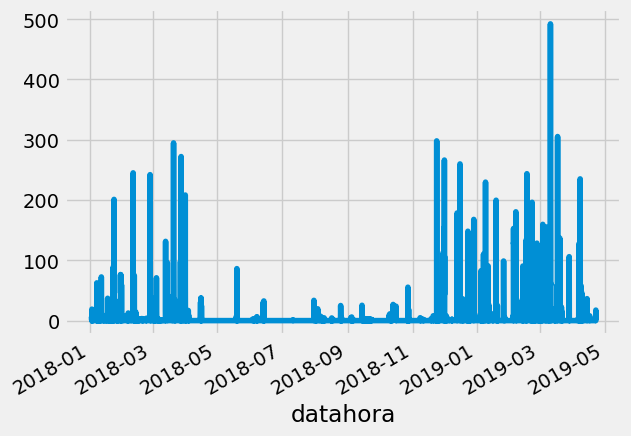

In [ ]:
# Grafico Simples
df_final_slim["precipitacao"].plot(kind = "line")

<AxesSubplot:>

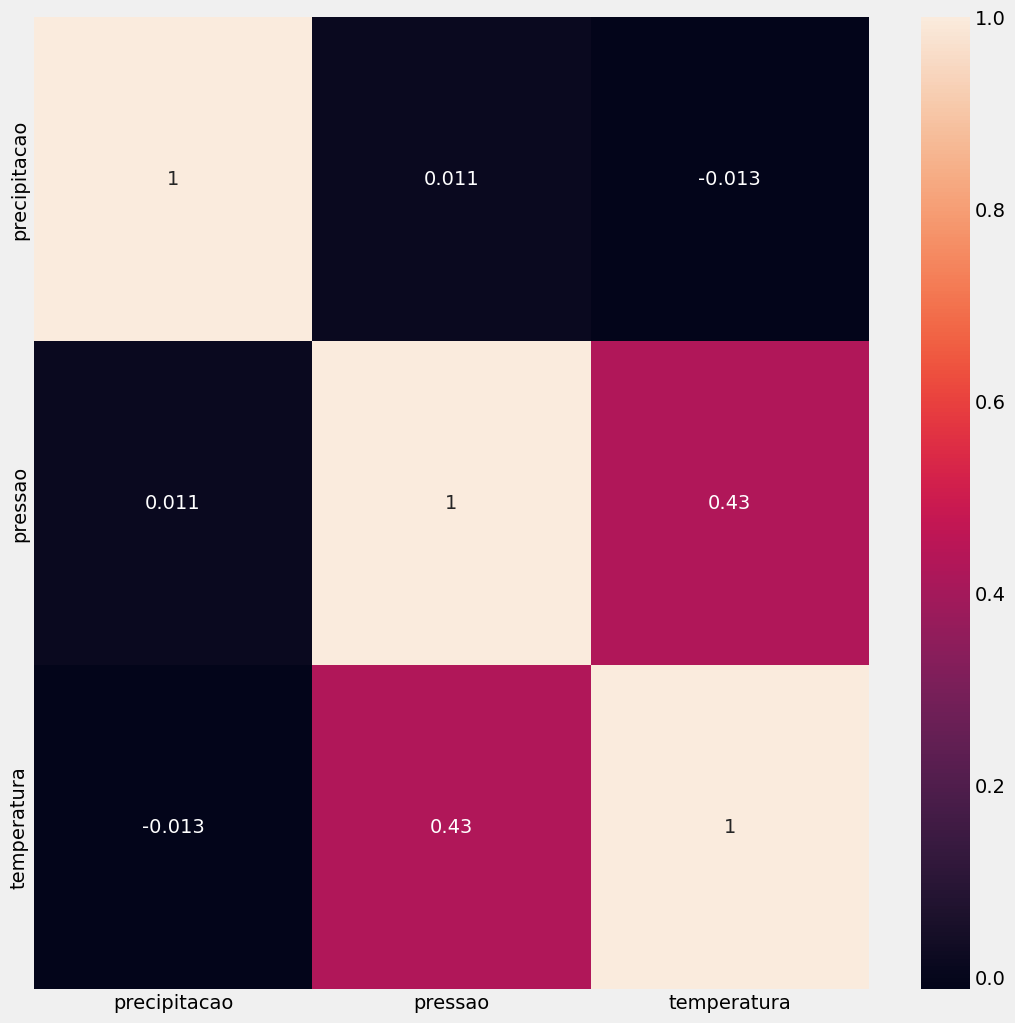

In [ ]:
### Correlação

## Notas do modeleiro firmeza
#1) menos temperatura mais chance de chuva,oposto para umidade
#2) Pressão está muito baixo para considerar
fig, ax = plt.subplots(figsize=(12,12))
sns.heatmap(df_final_slim.corr(),annot  = True, ax=ax)

In [ ]:
## Teste de estacionaridade

result = adfuller(endog, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'n_lags: {result[1]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')   

ADF Statistic: -15.912592506943536
n_lags: 8.091692754453082e-29
p-value: 8.091692754453082e-29
Critial Values:
   1%, -3.430922847323888
Critial Values:
   5%, -2.8617931679037603
Critial Values:
   10%, -2.5669047561757807


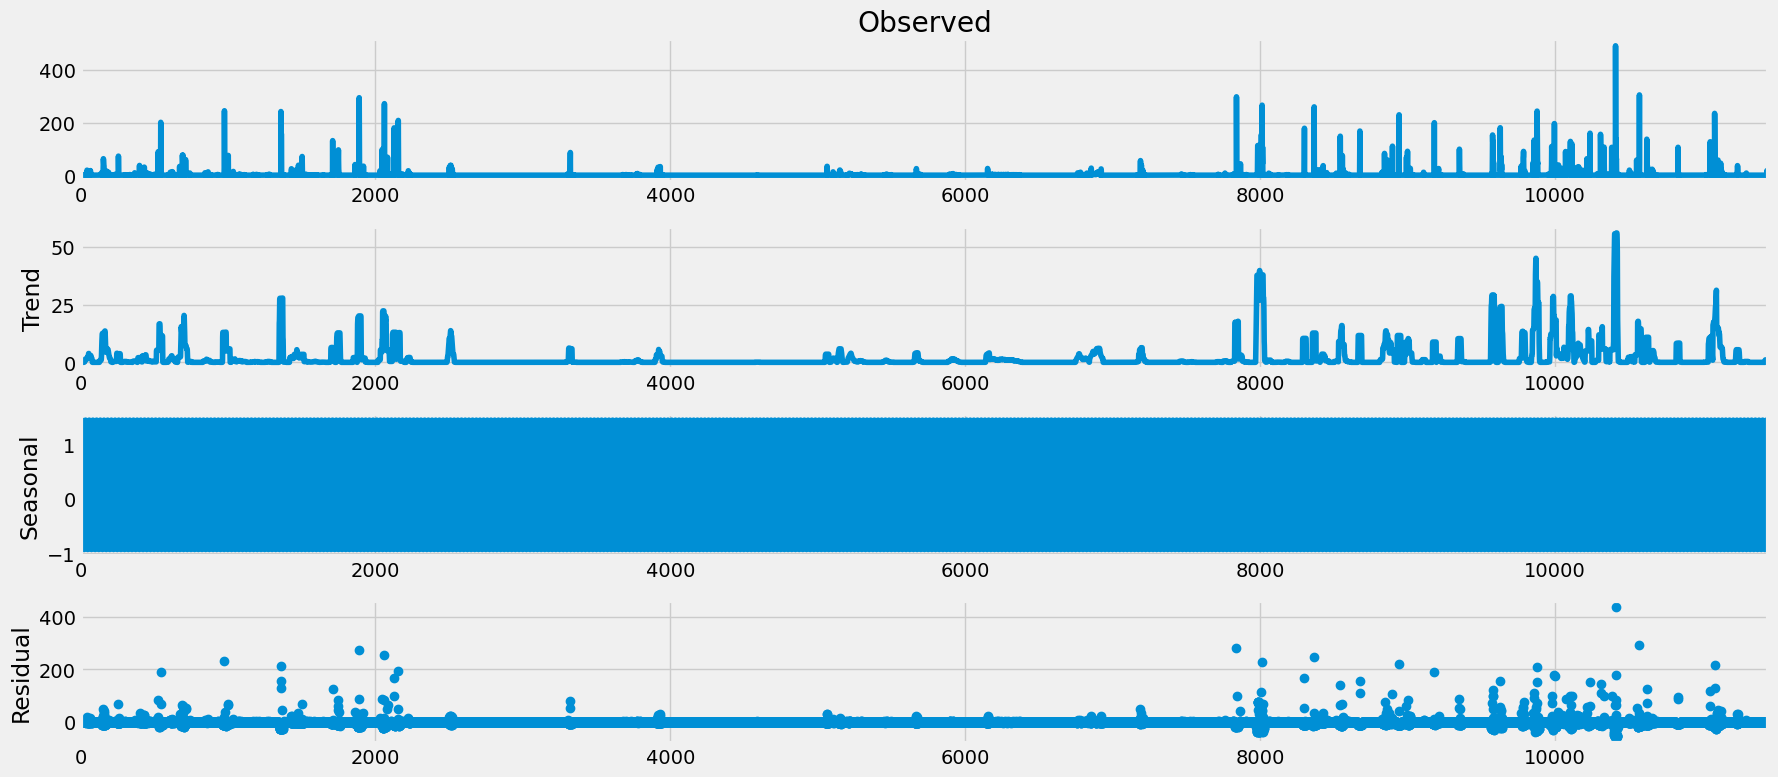

In [ ]:
#%% Data Decomposition
#1) Tem sazonalidade forte mas não tem tendencia
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(df_final_slim["precipitacao"].values, model='additive', period = 25)
fig = decomposition.plot()
plt.show()

In [ ]:
from pmdarima.arima.stationarity import ADFTest
from pmdarima.datasets import load_lynx
from pmdarima.arima.utils import nsdiffs
from sklearn.model_selection import TimeSeriesSplit

# Nível de Significância
adf_test = ADFTest(alpha=0.05)
p_val, should_diff = adf_test.should_diff(endog)
should_diff# (0.01, False)

False

In [ ]:
nsdiffs(endog,
            m=10,  # commonly requires knowledge of dataset
            max_D=12,
            test='ch')  # -> 0

# or use the OCSB test (by default)
nsdiffs(endog,
        m=10,
        max_D=12,
        test='ocsb')  # -> 0

0

In [ ]:
import numpy as np
import pmdarima as pm

split = int(endog.shape[0]*0.95)
endog_train = endog[:split]
endog_test = endog[split:]
exog_train = exog[:split]
exog_test = exog[split:]
stepwise_fit = pm.auto_arima(y=endog_train,X=exog_train, start_p=1, start_q=1,
                             max_p=12, max_q=12,
                            seasonal=False,
                             d=0,max_d=2, trace=True,   
                             error_action='ignore',  
                             suppress_warnings=True, 
                             stepwise=False,
                             random_state=123456,
                             time_varying_regression = True,
                             start_P=1,max_P=12,start_Q=1,max_Q=12)  

 ARIMA(0,0,0)(0,0,0)[0]             : AIC=89721.528, Time=2.56 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=87029.508, Time=1.84 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=86808.413, Time=4.79 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=86684.584, Time=3.23 sec
 ARIMA(0,0,4)(0,0,0)[0]             : AIC=86595.466, Time=5.95 sec
 ARIMA(0,0,5)(0,0,0)[0]             : AIC=86566.853, Time=7.89 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=86657.418, Time=1.76 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=86654.579, Time=1.64 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=86514.158, Time=4.56 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=86513.531, Time=5.27 sec
 ARIMA(1,0,4)(0,0,0)[0]             : AIC=86514.640, Time=9.12 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=86656.874, Time=1.99 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=86623.301, Time=6.14 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=86514.250, Time=3.42 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=86515.184, Time=5.83

In [ ]:
from sklearn.metrics import mean_squared_error
from pmdarima.metrics import smape
## 07/11:Fazendo um novo forecast para os novos dados

def forecast_one_step(X):
    fc, conf_int = stepwise_fit.predict(n_periods=1, return_conf_int=True,X=X)
    return (
        fc.tolist()[0],
        np.asarray(conf_int).tolist()[0])

forecasts = []
confidence_intervals = []

y_test = endog_forecast

for new_ob in y_test:
    i = 0
    exog_forecast_aux = pd.DataFrame(exog_forecast.iloc[i]).T
    fc, conf = forecast_one_step(X=exog_forecast_aux)
    forecasts.append(fc)
    confidence_intervals.append(conf)

    # Atualizando o modelo existente com um pequeno numero de MLE steps
    stepwise_fit.update(y=new_ob,X=exog_forecast_aux)
    i = i +1

print(f"Mean squared error: {mean_squared_error(y_test,forecasts)}")
print(f"SMAPE: {smape(y_test, forecasts)}")

Mean squared error: 4.589423710917239
SMAPE: 186.08084977674122


In [ ]:
endog_forecast

data
2022-11-09 00:00:00    0.0
2022-11-09 01:00:00    0.0
2022-11-09 02:00:00    0.0
2022-11-09 03:00:00    0.0
2022-11-09 04:00:00    0.0
                      ... 
2022-11-14 08:00:00    0.0
2022-11-14 09:00:00    0.0
2022-11-14 10:00:00    0.0
2022-11-14 11:00:00    0.0
2022-11-14 12:00:00    0.0
Name: precipitacao, Length: 1759, dtype: float64

In [ ]:
df_endog_forecast = pd.DataFrame(endog_forecast)
df_endog_forecast['predicao_preciptacao'] = forecasts

In [ ]:
export_forcast = df_endog_forecast['predicao_preciptacao']

In [ ]:
# converte data
export_forcast.index = export_forcast.index.strftime('%Y-%m-%d, %H:%M:%S')
# Exporta base
export_forcast[~export_forcast.index.duplicated(keep='first')].to_json("/Users/leonardoarouck/Library/CloudStorage/GoogleDrive-santosarouck@gmail.com/Meu Drive/Maua/TCC/Nosso TCC/base_app_2.json")

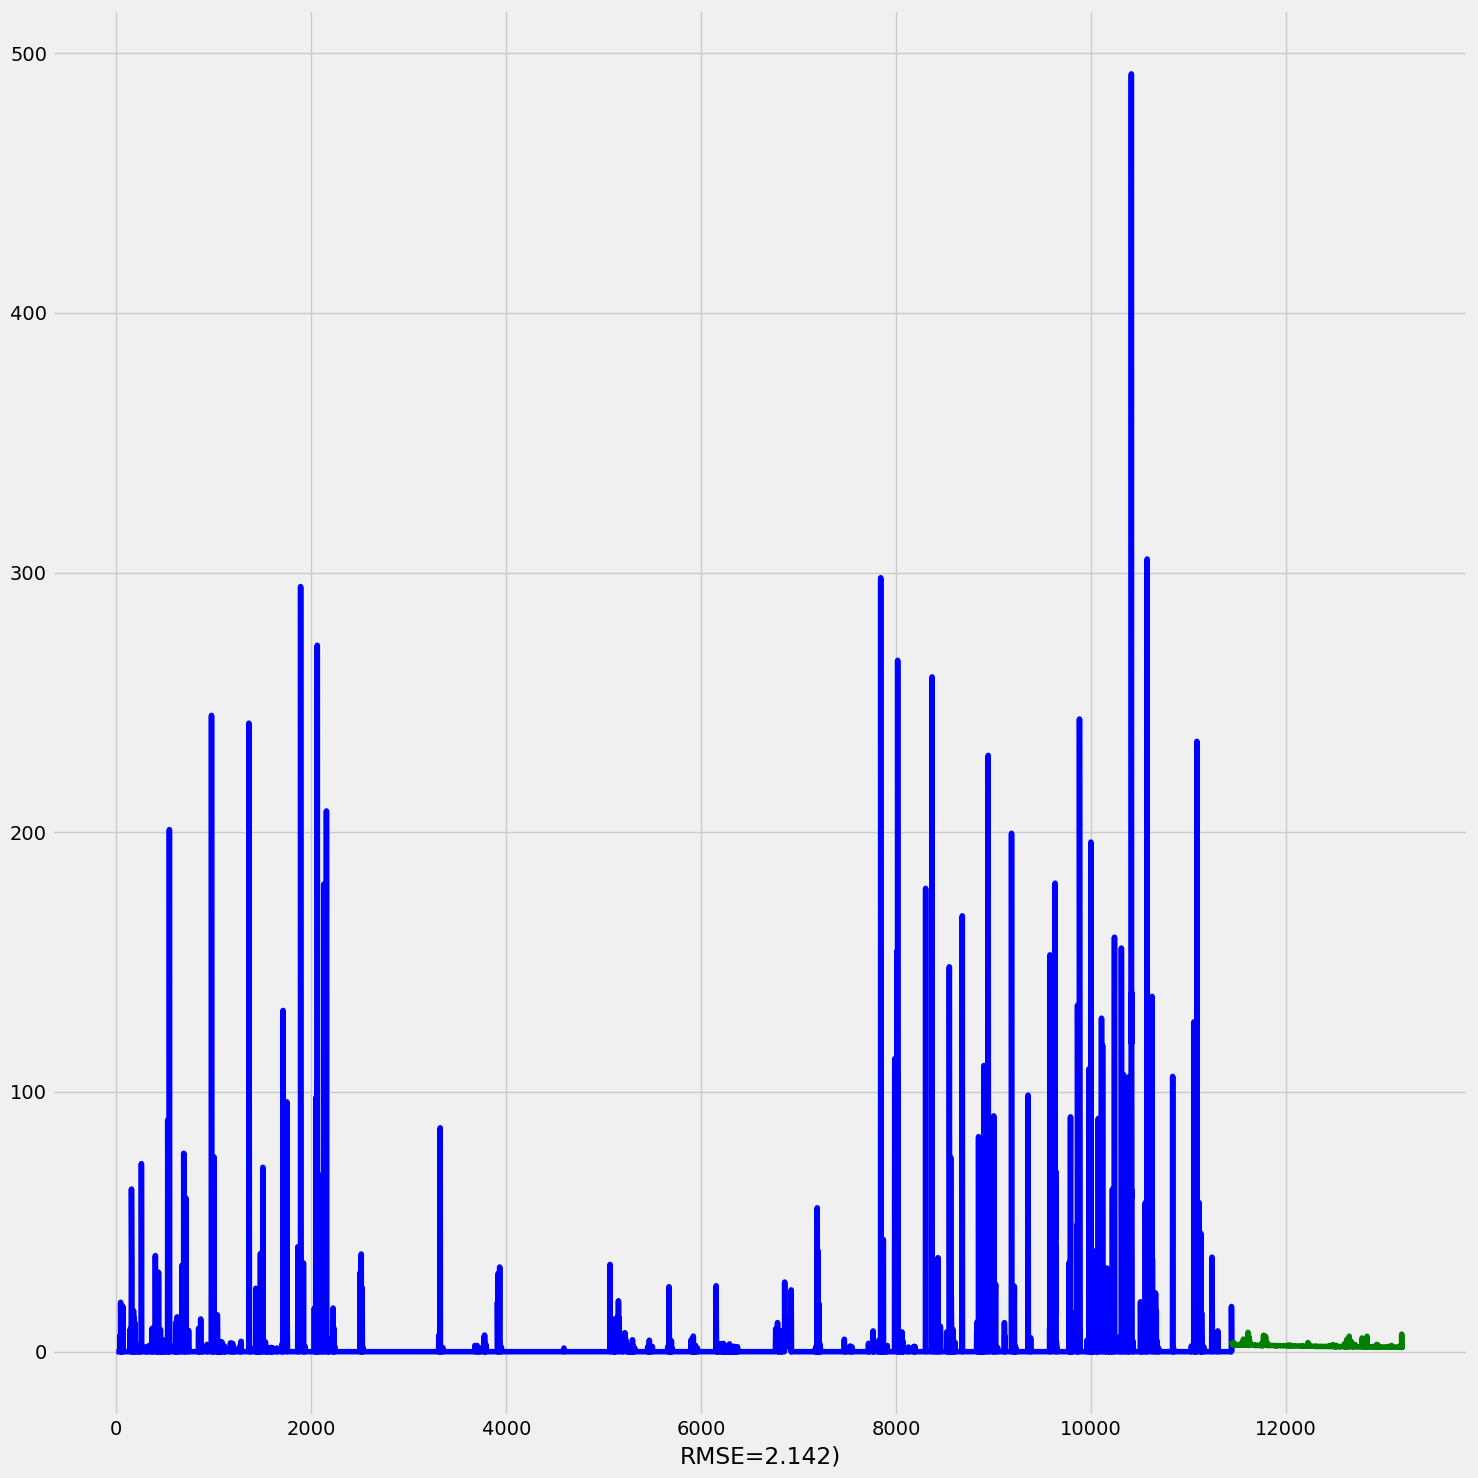

In [ ]:
from sklearn.metrics import mean_squared_error as mse


y_full  = pd.concat([endog_train,endog_test])

def plot_forecasts(forecasts, figsize=(8, 12)):
    
    forecasts = np.array(forecasts)
    x = np.arange(y_full.shape[0] + forecasts.shape[0])
    fig, axes = plt.subplots(1, 1, sharex=False, figsize=figsize)

    # Plot the forecasts
    axes.plot(x[:y_full.shape[0]], y_full, c='b')
    axes.plot(x[y_full.shape[0]:], forecasts, c='g')
    axes.set_xlabel(f'RMSE={np.sqrt(mse(y_test, forecasts)):.3f})')

    plt.tight_layout()
    plt.show()
    
plot_forecasts(forecasts, figsize=(15, 15))

In [ ]:
# import json
# x = """{
#     "2022-11-09, 00:00:00": 65,"2022-11-09, 01:00:00": 70,"2022-11-09, 02:00:00": 3.0023094451,"2022-11-09, 03:00:00": 2.7133810798,"2022-11-09, 04:00:00": 2.7030599259,"2022-11-09, 05:00:00": 2.6394969937,"2022-11-09, 06:00:00": 2.6274504052,"2022-11-09, 07:00:00": 2.6118650055,"2022-11-09, 08:00:00": 2.607467819,"2022-11-09, 09:00:00": 2.6072182057,"2022-11-09, 10:00:00": 2.6231370674,"2022-11-09, 11:00:00": 2.6018122466,"2022-11-09, 12:00:00": 2.6020469057,"2022-11-09, 13:00:00": 2.5987666172,"2022-11-09, 14:00:00": 2.5978842838,"2022-11-09, 15:00:00": 2.5990526003,"2022-11-09, 16:00:00": 3.5517300645,"2022-11-09, 17:00:00": 2.7491565219,"2022-11-09, 18:00:00": 2.9993424411,"2022-11-09, 19:00:00": 2.62392048,"2022-11-09, 20:00:00": 2.6954649432,"2022-11-09, 21:00:00": 2.6149231001,"2022-11-09, 22:00:00": 2.6191111082,"2022-11-09, 23:00:00": 2.6022395899,"2022-11-10, 00:00:00": 2.6085679343,"2022-11-10, 01:00:00": 2.5972115531,"2022-11-10, 02:00:00": 2.5964389062,"2022-11-10, 03:00:00": 2.5942838191,"2022-11-10, 04:00:00": 2.5935388453,"2022-11-10, 05:00:00": 2.5927497095,"2022-11-10, 06:00:00": 2.5943804662,"2022-11-10, 07:00:00": 2.5916098721,"2022-11-10, 08:00:00": 2.5960311968,"2022-11-10, 09:00:00": 2.6111438412,"2022-11-10, 10:00:00": 2.597237447,"2022-11-10, 11:00:00": 2.5998379361,"2022-11-10, 12:00:00": 2.6078208588,"2022-11-10, 13:00:00": 2.5941156653,"2022-11-10, 14:00:00": 2.5931489816,"2022-11-10, 15:00:00": 2.5970339932,"2022-11-10, 16:00:00": 2.6179316785,"2022-11-10, 17:00:00": 2.5887229993,"2022-11-10, 18:00:00": 2.5944283044,"2022-11-10, 19:00:00": 2.5892163459,"2022-11-10, 20:00:00": 2.6139078628,"2022-11-10, 21:00:00": 2.6666084789,"2022-11-10, 22:00:00": 2.6246399845,"2022-11-10, 23:00:00": 2.6331229384,"2022-11-11, 00:00:00": 2.6272012908,"2022-11-11, 01:00:00": 2.658490892,"2022-11-11, 02:00:00": 2.6549728041,"2022-11-11, 03:00:00": 2.6382601649,"2022-11-11, 04:00:00": 2.6147086272,"2022-11-11, 05:00:00": 2.6127367568,"2022-11-11, 06:00:00": 2.6196830813,"2022-11-11, 07:00:00": 2.6001942399,"2022-11-11, 08:00:00": 2.591073209,"2022-11-11, 09:00:00": 2.588712477,"2022-11-11, 10:00:00": 2.5860044984,"2022-11-11, 11:00:00": 2.5890021157,"2022-11-11, 12:00:00": 2.6039055482,"2022-11-11, 13:00:00": 2.5855476706,"2022-11-11, 14:00:00": 2.6070691023,"2022-11-11, 15:00:00": 2.5890404928,"2022-11-11, 16:00:00": 2.58627033,"2022-11-11, 17:00:00": 2.6004323492,"2022-11-11, 18:00:00": 2.5928315828,"2022-11-11, 19:00:00": 2.5836388693,"2022-11-11, 20:00:00": 2.5839631435,"2022-11-11, 21:00:00": 2.5857386159,"2022-11-11, 22:00:00": 2.601210046,"2022-11-11, 23:00:00": 2.5988794555,"2022-11-12, 00:00:00": 2.5979661814,"2022-11-12, 01:00:00": 2.622706514,"2022-11-12, 02:00:00": 2.6559900951,"2022-11-12, 03:00:00": 2.5861172926,"2022-11-12, 04:00:00": 2.5990296835,"2022-11-12, 05:00:00": 2.581971723,"2022-11-12, 06:00:00": 2.5831583656,"2022-11-12, 07:00:00": 2.5792497664,"2022-11-12, 08:00:00": 2.578900088,"2022-11-12, 09:00:00": 2.577760934,"2022-11-12, 10:00:00": 2.5773022641,"2022-11-12, 11:00:00": 2.5767584103,"2022-11-12, 12:00:00": 2.5765427184,"2022-11-12, 13:00:00": 2.5800734158,"2022-11-12, 14:00:00": 2.5834967559,"2022-11-12, 15:00:00": 3.0744319358,"2022-11-12, 16:00:00": 3.0535884944,"2022-11-12, 17:00:00": 2.6284470645,"2022-11-12, 18:00:00": 2.7184336144,"2022-11-12, 19:00:00": 2.599488875,"2022-11-12, 20:00:00": 2.7075212772,"2022-11-12, 21:00:00": 2.6041085356,"2022-11-12, 22:00:00": 2.6066595847,"2022-11-12, 23:00:00": 2.5870961097,"2022-11-13, 00:00:00": 2.5811502239,"2022-11-13, 01:00:00": 2.5769598657,"2022-11-13, 02:00:00": 2.5747943709,"2022-11-13, 03:00:00": 2.57337147,"2022-11-13, 04:00:00": 2.5725016642,"2022-11-13, 05:00:00": 2.5718766245,"2022-11-13, 06:00:00": 2.5714077064,"2022-11-13, 07:00:00": 2.5710152264,"2022-11-13, 08:00:00": 2.5706679103,"2022-11-13, 09:00:00": 2.5703438849,"2022-11-13, 10:00:00": 2.5701668516,"2022-11-13, 11:00:00": 2.5697596177,"2022-11-13, 12:00:00": 2.5694529253,"2022-11-13, 13:00:00": 2.5691498407,"2022-11-13, 14:00:00": 2.5771673881,"2022-11-13, 15:00:00": 3.8361258281,"2022-11-13, 16:00:00": 3.3391918548,"2022-11-13, 17:00:00": 3.3356230377,"2022-11-13, 18:00:00": 2.7829580943,"2022-11-13, 19:00:00": 4.827261204,"2022-11-13, 20:00:00": 2.5940498666,"2022-11-13, 21:00:00": 3.0829679422,"2022-11-13, 22:00:00": 2.6540165894,"2022-11-13, 23:00:00": 2.7404622707,"2022-11-14, 00:00:00": 2.5966766994,"2022-11-14, 01:00:00": 2.6087757296,"2022-11-14, 02:00:00": 2.5789848528,"2022-11-14, 03:00:00": 2.5768167985,"2022-11-14, 04:00:00": 2.5698055793,"2022-11-14, 05:00:00": 2.5681876128,"2022-11-14, 06:00:00": 2.5702293389,"2022-11-14, 07:00:00": 2.5730329115,"2022-11-14, 08:00:00": 2.5642836573,"2022-11-14, 09:00:00": 2.5658920317,"2022-11-14, 10:00:00": 2.56387007,"2022-11-14, 11:00:00": 2.5638220328,"2022-11-14, 12:00:00": 2.5630786639,"2022-11-14, 13:00:00": 2.5629189525,"2022-11-14, 14:00:00": 2.5665094011,"2022-11-14, 15:00:00": 2.5616715766,"2022-11-14, 16:00:00": 2.5626239882,"2022-11-14, 17:00:00": 3.5845952455,"2022-11-14, 18:00:00": 3.5277316493,"2022-11-14, 19:00:00": 2.9120714718,"2022-11-14, 20:00:00": 4.2912258582,"2022-11-14, 21:00:00": 3.9310708493,"2022-11-14, 22:00:00": 2.7359064578,"2022-11-14, 23:00:00": 2.9009536716,"2022-11-15, 00:00:00": 2.6521329721,"2022-11-15, 01:00:00": 2.6469265711,"2022-11-15, 02:00:00": 2.5927129436,"2022-11-15, 03:00:00": 2.5828634862,"2022-11-15, 04:00:00": 2.5697095783,"2022-11-15, 05:00:00": 2.5652425184,"2022-11-15, 06:00:00": 2.5616940033,"2022-11-15, 07:00:00": 2.5598621995,"2022-11-15, 08:00:00": 2.5587796439,"2022-11-15, 09:00:00": 2.5578901923,"2022-11-15, 10:00:00": 2.5574865064,"2022-11-15, 11:00:00": 2.5568998305,"2022-11-15, 12:00:00": 2.5566864613,"2022-11-15, 13:00:00": 2.5561924098,"2022-11-15, 14:00:00": 2.5601254292,"2022-11-15, 15:00:00": 2.6286579573,"2022-11-15, 16:00:00": 2.6894897399,"2022-11-15, 17:00:00": 4.0403716172,"2022-11-15, 18:00:00": 7.4237248857,"2022-11-15, 19:00:00": 2.3656483542,"2022-11-15, 20:00:00": 3.9061669985,"2022-11-15, 21:00:00": 3.7332199526,"2022-11-15, 22:00:00": 2.7777495223,"2022-11-15, 23:00:00": 2.8481766562,"2022-11-16, 00:00:00": 2.6457760776,"2022-11-16, 01:00:00": 2.6431821202,"2022-11-16, 02:00:00": 3.2134438499,"2022-11-16, 03:00:00": 3.4777915758,"2022-11-16, 04:00:00": 5.7625752165,"2022-11-16, 05:00:00": 3.5455621939,"2022-11-16, 06:00:00": 3.8672650933,"2022-11-16, 07:00:00": 4.2488752623,"2022-11-16, 08:00:00": 4.6148327297,"2022-11-16, 09:00:00": 4.0658286183,"2022-11-16, 10:00:00": 3.9592057455,"2022-11-16, 11:00:00": 3.8071581395,"2022-11-16, 12:00:00": 3.512649953,"2022-11-07, 01:00:00": 3.5277687621,"2022-11-07, 02:00:00": 2.7056516633,"2022-11-07, 03:00:00": 2.7918187338,"2022-11-07, 04:00:00": 2.6218696617,"2022-11-07, 05:00:00": 2.6129945686,"2022-11-07, 06:00:00": 2.5748220715,"2022-11-07, 07:00:00": 2.5669875493,"2022-11-07, 08:00:00": 2.5573467497,"2022-11-07, 09:00:00": 2.5541072019,"2022-11-07, 10:00:00": 2.551166869,"2022-11-07, 11:00:00": 2.5499974578,"2022-11-07, 12:00:00": 2.5571011466,"2022-11-07, 13:00:00": 2.5445139121,"2022-11-07, 14:00:00": 2.5441035382,"2022-11-07, 15:00:00": 2.5561738941,"2022-11-07, 16:00:00": 2.6850050511,"2022-11-07, 17:00:00": 2.6573420354,"2022-11-07, 18:00:00": 2.7675108089,"2022-11-07, 19:00:00": 2.6074381274,"2022-11-07, 20:00:00": 2.5885108242,"2022-11-07, 21:00:00": 2.5628576428,"2022-11-07, 22:00:00": 2.5590842139,"2022-11-07, 23:00:00": 2.5556899638,"2022-11-08, 00:00:00": 2.5571430925,"2022-11-08, 01:00:00": 2.5594407101,"2022-11-08, 02:00:00": 2.5424472794,"2022-11-08, 03:00:00": 2.5896507015,"2022-11-08, 04:00:00": 2.5799489746,"2022-11-08, 05:00:00": 2.5521797023,"2022-11-08, 06:00:00": 2.5604805441,"2022-11-08, 07:00:00": 2.5826538619,"2022-11-08, 08:00:00": 2.5671118539,"2022-11-08, 09:00:00": 2.5445660996,"2022-11-08, 10:00:00": 2.5457768722,"2022-11-08, 11:00:00": 2.5402743875,"2022-11-08, 12:00:00": 2.5395226057,"2022-11-08, 13:00:00": 2.5381192938,"2022-11-08, 14:00:00": 2.5375632279,"2022-11-08, 15:00:00": 2.5369968435,"2022-11-08, 16:00:00": 2.5366077226,"2022-11-08, 17:00:00": 2.8185348428,"2022-11-08, 18:00:00": 2.5712646654,"2022-11-08, 19:00:00": 2.6490624636,"2022-11-08, 20:00:00": 2.5590061641,"2022-11-08, 21:00:00": 2.5590763781,"2022-11-08, 22:00:00": 2.5437149361,"2022-11-08, 23:00:00": 2.5408652091
# }"""

# resposta_app = json.loads(x)

In [ ]:
# contador = 0
# for key in resposta_app:
#     if resposta_app[key] > 60:
#         print(f"Risco de alagamento em {key} evite a região")
#         contador =+ 1
# if contador == 0 :
#     print("sem risco de alagamento")